In [7]:
# Import Libraries for one hot encoding to convert labels and plotting RMSE and Mean error against epoch to check performance
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt #To plot the reduction in error
import sklearn # To plot ROC
from sklearn import metrics #To plot confusion matrix
import seaborn as sns #Heat map used for confusion matrix
from mnist import MNIST # To unload the ubyte data - Image data set
import itertools
import time

# Load the data set using MNIST library from your local directory
mndata = MNIST('samples')
images1, labels1 = mndata.load_training()
# and
images2, labels2 = mndata.load_testing()

# Merge train dataset with class column
train = pd.DataFrame(images1)
train['Target'] = labels1

# Merge test dataset with class column
test = pd.DataFrame(images2)
test['Target'] = labels2

In [8]:
train = train.loc[(train['Target'] == 3) | (train['Target'] == 9)]
test = test.loc[(test['Target'] == 3) | (test['Target'] == 9)]

# Shuffling the data
train = train.sample(frac=1)
test = test.sample(frac=1)

In [9]:
# Convert all feature attributes or pixels to matrix format
train_y = train["Target"]
train_x = train.drop(['Target'], axis=1).as_matrix()

test_y = test["Target"]
test_x = test.drop(['Target'], axis=1).as_matrix()

# Normalize the features by dividing it with maximum pixel value.
train_x = sklearn.preprocessing.normalize(train_x, norm='max')
test_x = sklearn.preprocessing.normalize(test_x, norm='max')

# Converting labels to numpy array
train_y = np.asarray(train_y).reshape(len(train_y), 1)
test_y = np.asarray(test_y).reshape(len(test_y), 1)
train_y = np.where(train_y == 3, 0, 1).reshape(len(train_y), 1)
test_y = np.where(test_y == 3, 0, 1).reshape(len(test_y), 1)

### Principal Component Analysis (PCA) - Reduction in Dimensionality
   Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of
   observations possibly correlated variables into a set of values of linearly uncorrelated variables called principal
   components. The number of distinct principal components is equal to the smaller of the number of original variables or 
   the number of observations minus one. This transformation is defined in such a way that the first principal component has 
   the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each 
   succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding  
   components.
   Ref: https://en.wikipedia.org/wiki/Principal_component_analysis.
   
          Procedure to reduce dimensionality:
           - First calculate (X.T * X) i.e find transpose of input matrix and multiply with the same (dot product).
           - Calculate Eigen Values (Lambda) and Eigen Vectors (W) of the above.
           - Eigen Value matrix is a ordered diagnol matrix. Where, each column in W represents principal components
           - 1st principal component correspond to largest eigen value, explains highest variation in data and the 2nd column 
             W represents 2nd principal component corresponding to 2nd largest eigen value and so on.
           - Now we need to select the number of transformed dimensions where it should explain most of the variance.
           - Taking cut off as 95% variance in original data from below graph we are selectingg 400 transformed features to 
             train our model.
           - For this decison we need to plot cummulative sum of eigen values (Lamdbda) in Y axis and number of transformed 
             features in x axis.
           - Selected Number of dimension is 400.
           - Using this transformed features to train Neural Network Model
    
Ref: https://www.youtube.com/watch?v=7WqWoEKUdQY&t=383s

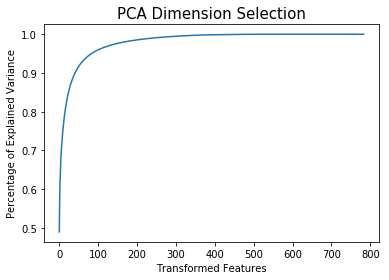

In [10]:
# Training Data
c = np.dot(train_x.T, train_x)
Lambda_tr, W_tr = np.linalg.eig(c)
Lambda_tr = np.real(Lambda_tr)
W_tr = np.real(W_tr)
cum_sum = np.cumsum(Lambda_tr)
per = cum_sum/cum_sum[-1]
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Transformed Features")
plt.title("PCA Dimension Selection",  size=15)
plt.plot(per)
plt.show()

# Testing Data
d = np.dot(test_x.T, test_x)
Lambda_te, W_te = np.linalg.eig(d)
Lambda_te = np.real(Lambda_te)
W_te = np.real(W_te)

In [11]:
Tr_train_x = np.dot(train_x, W_tr[:,:400])
Tr_test_x = np.dot(test_x, W_te[:,:400])

# Transformed Training and Testing data
train_x = Tr_train_x
test_x = Tr_test_x

In [12]:
#0.0009 and 200
class NeuralNet():
    def __init__(self, train_x, train_y, test_x, 
                 test_y, hidden_layers = 2, hidden_node = 90, learning_rate=0.01, epoch=70, regParam=0.01):
        self.op_node = 1                                # for binary classifier required output node should be 1.
        self.learning_rate= learning_rate               # learning rate requied to apply on gradients
        self.hidden_node = hidden_node                  # number of hidden nodes in each layer
        self.hidden_layers = hidden_layers              # number of hidden layers ie. 1 or 2
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.input_node = train_x.shape[1]              # number of input nodes......ideally should be 784 
        self.epoch = epoch                              # number of training epochs required 
        self.train_predict = None                       # to predict for training set
        self.error = None                               # difference in actual and predict in training set
        self.test_predict = None                        # to predict for testing set
        self.regParam = regParam                        # regularisation term to control weight values
        self.rmse = None                                # Root mean squared error 
        self.root_mse = None                            # Mean squared error
        self.t = None

        
        np.random.seed(10)
        # Initialising Random Weights
        if self.hidden_layers == 1:
            self.w1_ly1 = np.random.randn(self.input_node, self.hidden_node)  # shape is (784, number of hid. nodes in 1st layer)
            self.b1_ly1 = np.zeros((1, self.hidden_node))                     # shape is (1, number of hid. nodes in 1st layer)
            self.w2_ly2 = np.random.randn(self.hidden_node, self.op_node)     # shape is (number of hid. nodes in 1st layer, 1)
            self.b2_ly2 = np.zeros((1, self.op_node))                         # shape is (1, 1)
        
        if self.hidden_layers == 2:
            self.w1_ly1 = np.random.randn(self.input_node, self.hidden_node) # shape is (784, number of hid. nodes in 1st layer)
            self.b1_ly1 = np.zeros((1, self.hidden_node))                    # shape is (1, number of hid. nodes in 1st layer)
            self.w2_ly2 = np.random.randn(self.hidden_node, self.hidden_node)# shape is (number of hid. nodes in 1st layer, 
                                                                             #           number of hid. nodes in 2nd layer)
            self.b2_ly2 = np.zeros((1, self.hidden_node))                    # shape is (1, number of hid. nodes in 2nd layer)
            self.w3_ly3 = np.random.randn(self.hidden_node, self.op_node)    # shape is (number of hid. nodes in 2nd layer, 1)
            self.b3_ly3 = np.zeros((1, self.op_node))                        # shape is (1, 1)
            
    
    #Sigmoid Activation Function
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
        
#****************************************************************************************************************************#        
    # Update weights and biases using delta values derived from backpropogation
    #         restricting the weights to certain limit. 
    # To update weights W = W - learning_rate*(Vd corrected + sqrt(Sd corrected + epsilon))
    # To update bias b = b - learning_rate*(Vb corrected + sqrt(Sb corrected + epsilon))  
    
    def adam_gradient_descent(self, vdw1, vdw2, vb1, vb2, sdw1, sdw2, sb1, sb2, vdw3=0, vb3=0, sdw3=0, sb3=0):
        epsilon = 0.0000001
        
        if self.hidden_layers ==1:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(vdw1/np.sqrt(sdw1+epsilon))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(vdw2/np.sqrt(sdw2+epsilon))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*(vb1/np.sqrt(sb1+epsilon))
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*(vb2/np.sqrt(sb2+epsilon))
        
        if self.hidden_layers ==2:
            self.w1_ly1 = self.w1_ly1 - self.learning_rate*(vdw1/np.sqrt(sdw1+epsilon))
            self.w2_ly2 = self.w2_ly2 - self.learning_rate*(vdw2/np.sqrt(sdw2+epsilon))
            self.w3_ly3 = self.w3_ly3 - self.learning_rate*(vdw3/np.sqrt(sdw3+epsilon))
            self.b1_ly1 = self.b1_ly1 - self.learning_rate*(vb1/np.sqrt(sb1+epsilon))
            self.b2_ly2 = self.b2_ly2 - self.learning_rate*(vb2/np.sqrt(sb2+epsilon))
            self.b3_ly3 = self.b3_ly3 - self.learning_rate*(vb3/np.sqrt(sb3+epsilon))
        
        
#******************************************************************************************************************************#
#                                                TRAINING PHASE
#******************************************************************************************************************************#
    # Initialising all required parameters for Adam optimization
    def trainNN(self):
        rmse = []
        root_mse = []
        
        for ep in range(self.epoch):
            s = 0
            error = []
            act_func = []
            self.t = 1
            vdw1 = 0
            vdw2 = 0
            vdw3 = 0
            sdw1 = 0
            sdw2 = 0
            sdw3 = 0
            vb1 = 0
            vb2 = 0
            vb3 = 0
            sb1 = 0
            sb2 = 0
            sb3 = 0
            beta1 = 0.9
            beta2 = 0.999
            
            for batch in [1000, 2000, 3000, 4000, 5000, 6000, 7000]: # No of batches for mini batch gradient descent
                train_x = self.train_x[s:batch]                      # Creating the the 7 batches as it go throughs the loop
                train_y = self.train_y[s:batch]
                
                s=s+len(train_x)                                     # This is used to calculate V corrected and S corrected
                
                if self.hidden_layers == 1:
                    # Step 1: Forward Feed Working
                    # For each layer from network, Perform:
                    #     z = Wx + b
                    #     sigmoid(z)
                    # Get mean error and RMSE to check performance later on
                    a1 = train_x
                    z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                    a2 = self.activation(z2)
                    z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                    a3 = self.activation(z3)
                    er = a3 - train_y
                    error.append(er)

                    # Step 2: Backward propogation Working
                    # It involves 2 task.
                    #      getting delta value for output layer
                    #      getting delta value for inner layers
                    delta2 = er*a3*(1-a3)  # a3*(1-a3) is same as derivative of sigmoid finction
                    delta1 = np.dot(delta2, self.w2_ly2.T)*a2*(1 - a2)
                    tdelta2 = np.dot(a2.T, delta2)
                    tdelta1 = np.dot(train_x.T, delta1)
                    tb2 = np.sum(delta2, axis=0).reshape(1, self.op_node)
                    tb1 = np.sum(delta1,axis=0).reshape(1, self.hidden_node)
                    act_func.append(a3)
                    
                    # Computinh the all necessary parameters as mentioned in above description
                    self.t = self.t+1
                    vdw1 = ((vdw1*beta1)+((1-beta1)*tdelta1))/(1-beta1**self.t)
                    vdw2 = ((vdw2*beta1)+((1-beta1)*tdelta2))/(1-beta1**self.t)
                    vb1 = ((vb1*beta1)+((1-beta1)*tb1))/(1-beta1**self.t)
                    vb2 = ((vb2*beta1)+((1-beta1)*tb2))/(1-beta1**self.t)
                    sdw1 = ((sdw1*beta2)+((1-beta2)*np.square(tdelta1)))/(1-beta2**self.t)
                    sdw2 = ((sdw2*beta2)+((1-beta2)*np.square(tdelta2)))/(1-beta2**self.t)
                    sb1 = ((sb1*beta2)+((1-beta2)*np.square(tb1)))/(1-beta2**self.t)
                    sb2 = ((sb2*beta2)+((1-beta2)*np.square(tb2)))/(1-beta2**self.t)
                    self.adam_gradient_descent(vdw1, vdw2, vb1, vb2, sdw1, sdw2, sb1, sb2)

                if self.hidden_layers == 2:
                    # Step 1: Forward Feed Working
                    # For each layer from network, Perform:
                    #     z = Wx + b
                    #     sigmoid(z)
                    # Get mean error and RMSE to check performance later o
                    a1 = train_x
                    z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                    a2 = self.activation(z2)
                    z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                    a3 = self.activation(z3)
                    z4 = np.dot(a3, self.w3_ly3) + self.b3_ly3
                    a4 = self.activation(z4)
                    er = a4 - train_y
                    error.append(er)

                    # Step 2: Backward propogation Working
                    # It involves 2 task.
                    #      getting delta value for output layer
                    #      getting delta value for inner layers
                    delta2 = er*a3*(1-a3)  # a3*(1-a3) is same as derivative of sigmoid fincti
                    delta3 = er*a4*(1-a4)
                    delta2 = np.dot(delta3, self.w3_ly3.T)*a3*(1 - a3)
                    delta1 = np.dot(delta2, self.w2_ly2.T)*a2*(1 - a2)
                    tdelta3 = np.dot(a3.T, delta3)
                    tdelta2 = np.dot(a2.T, delta2)
                    tdelta1 = np.dot(train_x.T, delta1)
                    tb3 = np.sum(delta3, axis=0).reshape(1, self.op_node)
                    tb2 = np.sum(delta2,axis=0).reshape(1, self.hidden_node)
                    tb1 = np.sum(delta1,axis=0).reshape(1, self.hidden_node)
                    act_func.append(a4)
                    
                    # Computing the all necessary parameters as mentioned in above description
                    self.t = self.t+1
                    vdw1 = ((vdw1*beta1)+((1-beta1)*tdelta1))/(1-beta1**self.t)
                    vdw2 = ((vdw2*beta1)+((1-beta1)*tdelta2))/(1-beta1**self.t)
                    vdw3 = ((vdw3*beta1)+((1-beta1)*tdelta3))/(1-beta1**self.t)
                    vb1 = ((vb1*beta1)+((1-beta1)*tb1))/(1-beta1**self.t)
                    vb2 = ((vb2*beta1)+((1-beta1)*tb2))/(1-beta1**self.t)
                    vb3 = ((vb3*beta1)+((1-beta1)*tb3))/(1-beta1**self.t)
                    sdw1 = ((sdw1*beta2)+((1-beta2)*np.square(tdelta1)))/(1-beta2**self.t)
                    sdw2 = ((sdw2*beta2)+((1-beta2)*np.square(tdelta2)))/(1-beta2**self.t)
                    sdw3 = ((sdw3*beta2)+((1-beta2)*np.square(tdelta3)))/(1-beta2**self.t)
                    sb1 = ((sb1*beta2)+((1-beta2)*np.square(tb1)))/(1-beta2**self.t)
                    sb2 = ((sb2*beta2)+((1-beta2)*np.square(tb2)))/(1-beta2**self.t)
                    sb3 = ((sb3*beta2)+((1-beta2)*np.square(tb3)))/(1-beta2**self.t)
                    # Calling adam_gradient_descent function to update weights
                    self.adam_gradient_descent(vdw1, vdw2, vb1, vb2, sdw1, sdw2, sb1, sb2, vdw3, vb3, sdw3, sb3)
                    
            # These are used to calculate mean error and rmse for plotting      
            act_func = list(itertools.chain.from_iterable(act_func))
            error = list(itertools.chain.from_iterable(error))
            act_func = np.asarray(act_func).reshape(len(act_func), 1)
            error = np.asarray(error).reshape(len(error), 1)
            mean_error = np.sum(error)/len(error)
            rmse.append(mean_error)
            root_error = np.sqrt(np.sum(error**2)/len(error))
            root_mse.append(root_error)
            self.error = np.asarray(error)
            self.train_predict = np.asarray(act_func)
            
            # To keep track of our training.
            if ep in [1, 4, 6, 10, 20, 30, 40, 50, 60, 65, 69, 99]:
                accuracy = 1-np.sum(abs(np.asarray(error)))/len(np.asarray(error))
                print("Accuracy is:  {0:.4f}, for epoch:{1}".format(accuracy, ep))
                    
        self.rmse = rmse
        self.root_mse = root_mse
        
#*******************************************************************************************************************************#
#                                               TESTING PHASE
#*******************************************************************************************************************************#
        
    def predict_digit(self):
        
        if self.hidden_layers == 1:
                #Forward Feed
                a1 = self.test_x
                z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                a2 = self.activation(z2)
                z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                a3 = self.activation(z3)
                
                self.test_predict = np.round(a3)
        
        if self.hidden_layers == 2:
                #Forward Propogation
                a1 = self.test_x
                z2 = np.dot(a1, self.w1_ly1) + self.b1_ly1
                a2 = self.activation(z2)
                z3 = np.dot(a2, self.w2_ly2) + self.b2_ly2
                a3 = self.activation(z3)
                z4 = np.dot(a3, self.w3_ly3) + self.b3_ly3
                a4 = self.activation(z4)
                
                self.test_predict = np.round(a4)

Accuracy is:  0.5194, for epoch:1
Accuracy is:  0.7254, for epoch:4
Accuracy is:  0.8242, for epoch:6
Accuracy is:  0.8825, for epoch:10
Accuracy is:  0.9415, for epoch:20
Accuracy is:  0.9734, for epoch:30
Accuracy is:  0.9825, for epoch:40
Accuracy is:  0.9866, for epoch:50
Accuracy is:  0.9893, for epoch:60
Accuracy is:  0.9902, for epoch:65
Accuracy is:  0.9901, for epoch:69
Accuracy is:  0.9936, for epoch:99


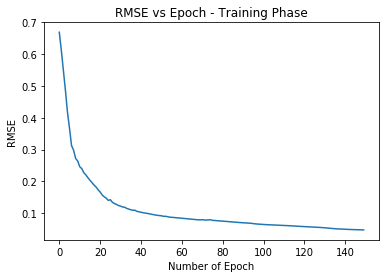

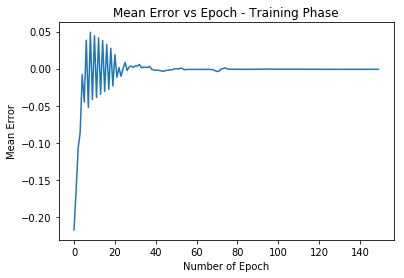

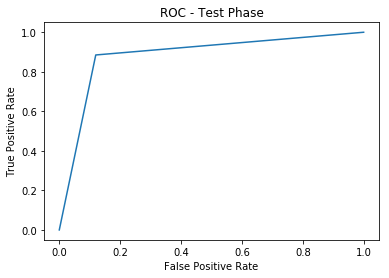

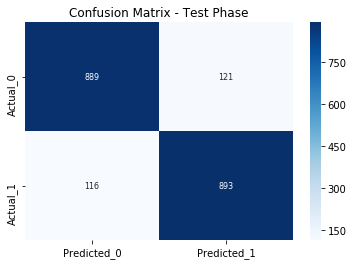

Test Accuracy:  0.882615156018
Elapsed Time For Training is:  17.166849851608276


In [13]:
# Implementation of Adam Optimization
#*****************************************************************************************

start_time = time.time()                                    # Start the time to check the execution time

# Starting model with training of network
pca = NeuralNet(train_x, train_y, test_x, test_y)
pca.trainNN()

# Use the trained model to predict digits
# Testing the model once we have statisfied with the result of training
# Note: Test set or held out set is never used to evaluate the model during the training phase
pca.predict_digit()

# Check performance by plotting RMSE and Mean Error (Mean Error can be -ve or +ve)
plt.plot(pca.root_mse)
plt.title("RMSE vs Epoch - Training Phase")
plt.xlabel("Number of Epoch")
plt.ylabel("RMSE")
plt.show()


plt.plot(pca.rmse)
plt.title("Mean Error vs Epoch - Training Phase")
plt.xlabel("Number of Epoch")
plt.ylabel("Mean Error")
plt.show()

# Ploting ROC curve for testing phase or model evaluation
fpr, tpr, thresholds = sklearn.metrics.roc_curve(pca.test_y, pca.test_predict, 
                                                 pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr)
plt.title("ROC - Test Phase")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Generate Confusion Matrix
ax=plt.axes()
arr = metrics.confusion_matrix(pca.test_y, pca.test_predict, sample_weight=None)
con_df = pd.DataFrame(arr, columns = ["Predicted_0", "Predicted_1"], index=["Actual_0", "Actual_1"])
sns.heatmap(con_df, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Test Phase')
plt.show()

accpca = 1-np.sum(abs(pca.test_y - pca.test_predict))/len(pca.test_predict)
print('Test Accuracy: ', accpca)
elapsed_time3 = time.time() - start_time
print("Elapsed Time For Training is: ", elapsed_time3)

In [14]:
test_y

array([[1],
       [1],
       [1],
       ..., 
       [1],
       [1],
       [1]])

In [15]:
pca.test_predict

array([[ 0.],
       [ 1.],
       [ 1.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])